# Improving Upon PyTorch's Optimizers

#### Last Time
[Most recently](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/08_data_block_my_reimplementation.ipynb?flush_cache=true) we learned out to implement our own version of the fastai library's [data block API](https://docs.fast.ai/data_block.html). This effort centered around the creation of classes that could:
1. Assemble and store a list of paths to a dataset's image files, and keep track of any preprocessing transforms that will be applied.
2. Split the dataset into training and validation sets and remember which files belong where.
3. Curate a vocabulary of class label-to-integer index mappings from the training set, and create label lists for items in the training and validation sets.

The payoff to the somewhat sizable amount of work necessary to implement the above is that we can now execute all steps necessary to prepare an imageset for training, from initial download, onward, in just a couple lines of code. We'll see this in action just a few cells below, when we prepare the [Imagenette dataset](https://github.com/fastai/imagenette/blob/master/README.md) for use in this notebook.

#### Optimizers
Today we turn our attention to optimizers. We'll see that the basic optimizer class in PyTorch's `torch.optim` package is nothing more than a dictionary that stores:
1. The model's hyperparameters
2. The model's parameter groups, and which parameters belong in which group.

PyTorch optimizers also contain a `step()` method that updates parameters with gradients calculated during each mini-batch's backward pass, as well as a `zero_grad()` method that detaches and zeroes out gradients upon completion of the gradient update.

We'll see how to build an identical implementation of our own from scratch. What's more, our version will be more flexible, as it will allow a practitioner to define and use whichever stepper function (in other words, whichever optimizing algorithm + enhancements such as weight decay and momentum) they prefer. These will include [stochastic gradient descent](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part1_v3/blob/master/lesson2-sgd-my-reimplementation.ipynb?flush_cache=true), [Adam](https://arxiv.org/abs/1412.6980), and even the relatively recent [LAMB optimizer](https://arxiv.org/pdf/1904.00962.pdf)!

#### Refactoring out the `Runner` Class and Adding a Training Progress Bar
We wrap up this notebook by completing two extra code maintenance/improvement steps that were covered at the end of [the lecture](https://youtu.be/hPQKzsjTyyQ). We first extend the function of our `Learner` class, and in the process obviate the need for also having a `Runner` class to manage the training cycle. This refactoring was originally covered in [notebook 09b](https://github.com/fastai/fastai_docs/blob/master/dev_course/dl2/09b_learner.ipynb). I then implement code introduced in [notebook 09c](https://github.com/fastai/fastai_docs/blob/master/dev_course/dl2/09c_add_progress_bar.ipynb), which adds a bar that can displays progress during training. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#export
from exports.nb_08 import *

### Preparing the Imagenette Imageset

In [3]:
#export
imagenette_url = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160'

In [4]:
path = datasets.untar_data(imagenette_url)
tfms = [MakeRGB(), ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs=128

data = (ImageList.from_files(path, tfms=tfms)
        .to_split(partial(grandparent_splitter, valid_name='val'))
        .to_label(parent_labeler, y_processor=CategoryProcessor())
        .to_databunch(bs, channels_in=3, channels_out=10, num_workers=4))

### Baseline Model
We'll train a quick baseline model using the CNN we defined toward the end of [the most recent notebook](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/08_data_block_my_reimplementation.ipynb?flush_cache=true). It uses PyTorch's vanilla SGD, `optim.SGD`, as its optimizer (`get_learn_run()` calls the `get_runner()` method, which is defined in [notebook 06](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/06_cuda_cnn_hooks_init_my_reimplementation.ipynb?flush_cache=true) as using `optim.SGD` by default if no optimizer is passed).

In [5]:
# Output sizes of final four layers of our CNN
n_outs = [64, 64, 128, 256]

callback_funcs = [partial(AvgStatsCallback, accuracy), CudaCallback, 
                  partial(BatchTransformXCallback, norm_imagenette)]

In [6]:
learn, run = get_learn_run(n_outs, data, lr=0.4, layer=conv_layer, cbs=callback_funcs)

In [7]:
run.fit(1, learn)

train: [1.7154385942589576, tensor(0.3975, device='cuda:0')]
valid: [1.405330322265625, tensor(0.5220, device='cuda:0')]


### Refining the PyTorch Optimizer

We're going to create a single `Optimizer` class that allows practitioners to pass in one or more functions defining optimizing algorithms when constructing an `Optimizer()` object. We'll label the argument that accepts such a list of functions as the class' `steppers` argument. 

What gets passed to `steppers` could be as simple as vanilla stochastic gradient descent. However, if we wanted, we could instead define, say, an Adam optimizer pass that in when constructing an `Optimizer()`. 

Additionally, since this argument will be able to handle a list containing several functions, further on down we'll demonstrate how we could use the `steppers` argrument to augment our optimizer with weight decay and or momentum, all without the creation of a completely new class.

In [8]:
#export 

# Helper method that takes a list of functions and applies 
# them, in order, to an item in the dataset. **kwargs allows us 
# to pass a group of hyperparameters from the hyperparameter 
# dict as arguments for each func.
def apply_functions(x, funcs, **kwargs):
    for func in listify(funcs): 
        x = func(x, **kwargs)
    return x

In [9]:
class Optimizer():
    def __init__(self, param_groups, steppers, **defaults):
        # param_groups could be a generator
        self.param_groups = list(param_groups) 
        # ensure param_groups is a list of lists
        if not isinstance(self.param_groups[0], list):
            self.param_groups = [self.param_groups]
        self.hyperparam_dicts = [{**defaults} for param_group in self.param_groups]
        self.steppers = listify(steppers)
        
    def grad_params(self):
        return [(param, hyperparam_dict) for param_group, hyperparam_dict in zip(self.param_groups, self.hyperparam_dicts)
               for param in param_group if param.grad is not None]
    
    def zero_grad(self):
        for param, hyperparam_dict in self.grad_params():
            param.grad.detach_()
            param.grad.zero_()
        
    def step(self):
        for param, hyperparam_dict in self.grad_params():
            apply_functions(param, self.steppers, **hyperparam_dict)

If we want to use a vanilla SGD optimizer, we just can define the following function and then pass it inside a list to the `steppers` argument:

In [10]:
#export
def sgd_step(param, lr, **kwargs):
    param.data.add_(-lr, param.grad.data)
    return param

In [11]:
opt_func = partial(Optimizer, steppers = [sgd_step])

Now that we've gone and defined our own home-grown `Optimizer` class, we need to reimplement three previously-implemented callbacks (`Recorder`, `ParamScheduler`, and `LR_Find`) that had been making use of properties from PyTorch's optimizer. 

More specifically, our optimizer stores hyperparameters inside the list of dictionaries, while PyTorch's optimizer stores hyperparameters right inside the same list that also contains the parameter groups. 

In [12]:
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs, self.losses = [], []
        
    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.hyperparam_dicts[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lr(self):  
        plt.xlabel('Iteration')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate')
        plt.plot(self.lrs)
        
    def plot_loss(self): 
        plt.xlabel('Iteration')
        plt.ylabel('Train Loss')
        plt.title('Training Loss')
        plt.plot(self.losses)
        
    def plot(self, skip_last=0):
        losses=[o.item() for o in self.losses]
        n = len(losses) - skip_last
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.ylabel('Train Loss')
        plt.title('Learning Rate Finder')
        plt.plot(self.lrs[:n], self.losses[:n])
        
class ParamScheduler(Callback):
    _order=1
    def __init__(self, param_name, sched_funcs):
        self.param_name, self.sched_funcs = param_name, listify(sched_funcs)
        
    def begin_batch(self):
        if not self.in_train: return
        fs = self.sched_funcs
        if len(fs)==1: fs = fs * len(self.opt.param_groups)
        pos = self.n_epochs/self.epochs
        for f,h in zip(fs, self.opt.hyperparam_dicts): h[self.param_name] = f(pos)
            
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter, self.min_lr, self.max_lr = max_iter, min_lr, max_lr
        self.best_loss = 1e9
        
    def begin_batch(self):
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for h in self.opt.hyperparam_dicts: h['lr'] = lr
            
    def after_step(self):
        if self.n_iter >= self.max_iter or self.loss > self.best_loss * 10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

Let's test out each of the above three callbacks and, of course, our `Optimizer` class: we'll first run the learning rate finder, and then train a simple model. Although we pass a learning rate value of `1.0` to `get_learn_run()`, because we're using the `LR_Find` callback, it doesn't really matter what value we pass. The callback will irregardless vary learning rate between `min_lr=1e-6` and `max_lr=10` (unfortunately, we don't have the option of passing `None`). 

In [13]:
callback_funcs = [CudaCallback, Recorder, LR_Find]
learn, run = get_learn_run(n_outs, data, lr=1., layer=conv_layer, cbs=callback_funcs, opt_func=opt_func)

In [14]:
run.fit(2, learn)

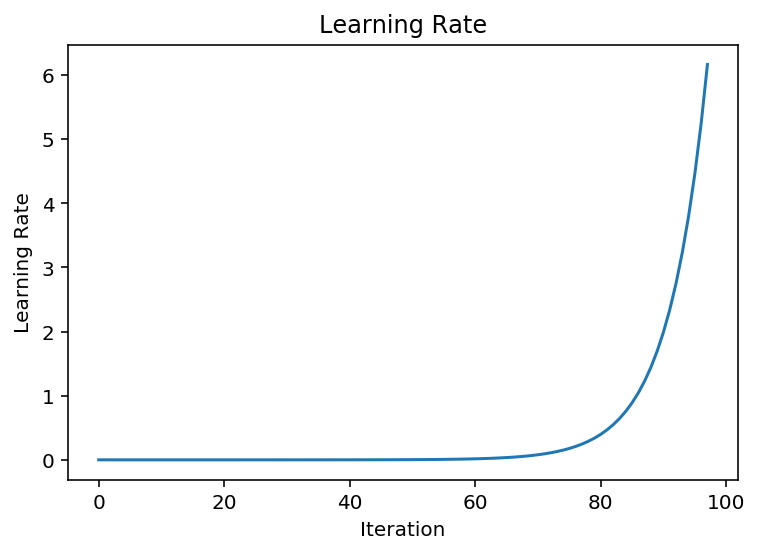

In [15]:
run.recorder.plot_lr()

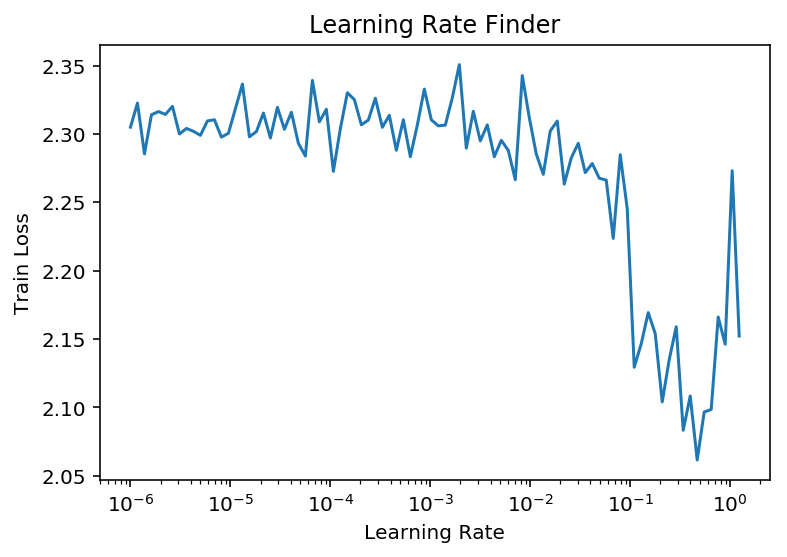

In [16]:
run.recorder.plot(skip_last=10)

Based on the heuristic discussed in [the notebook where early stopping was implemented](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/05b_early_stopping_my_reimplementation.ipynb?flush_cache=true), it appears `3e-1` will be a good max learning rate.

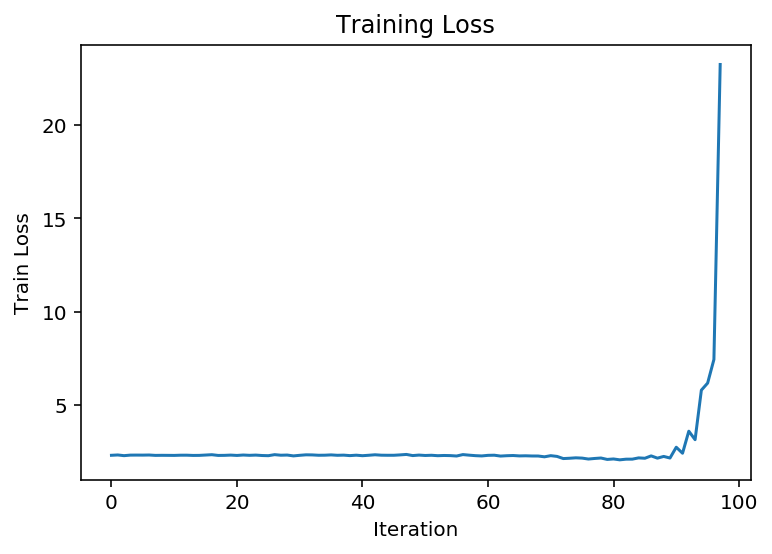

In [17]:
run.recorder.plot_loss()

Now let's train a quick model. We'll use cosine learning rate warm-up and annealing. Similar to the case above with the `LR_Find` callback, it doesn't matter what learning rate we pass to `get_learn_run()`. The `ParamScheduler` callback will override this with the scheduled values.

In [18]:
lr=3e-1
sched = combine_scheds([0.3, 0.7], [sched_cos(lr/2, lr), sched_cos(lr, (lr/2 - lr/10))])
callback_funcs = [partial(AvgStatsCallback, accuracy),
                  CudaCallback, Recorder,
                  partial(ParamScheduler, 'lr', sched)]
learn, run = get_learn_run(n_outs, data, lr, layer=conv_layer, cbs=callback_funcs, opt_func=opt_func)

In [ ]:
%time run.fit(1, learn)

train: [1.804024946195905, tensor(0.3709, device='cuda:0')]
valid: [1.68676708984375, tensor(0.4460, device='cuda:0')]
CPU times: user 8.97 s, sys: 3.15 s, total: 12.1 s
Wall time: 13.3 s


Let's verify that learning rate did indeed vary according to our desired schedule:

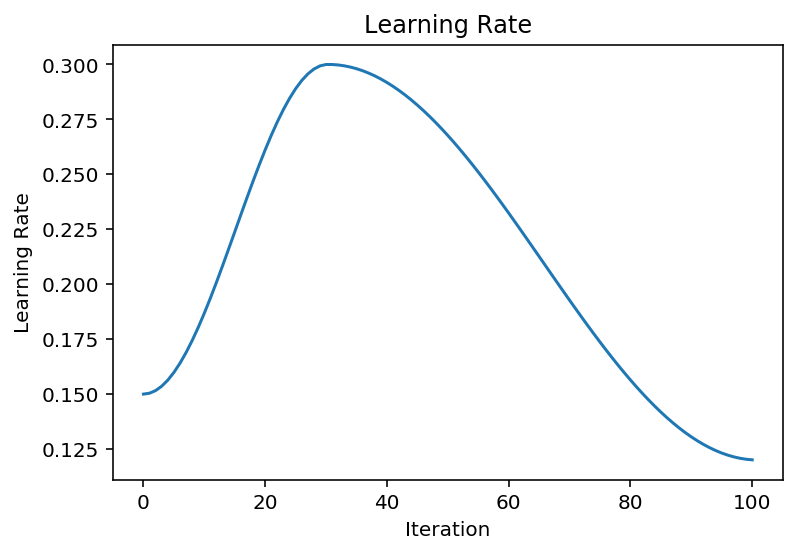

In [ ]:
run.recorder.plot_lr()

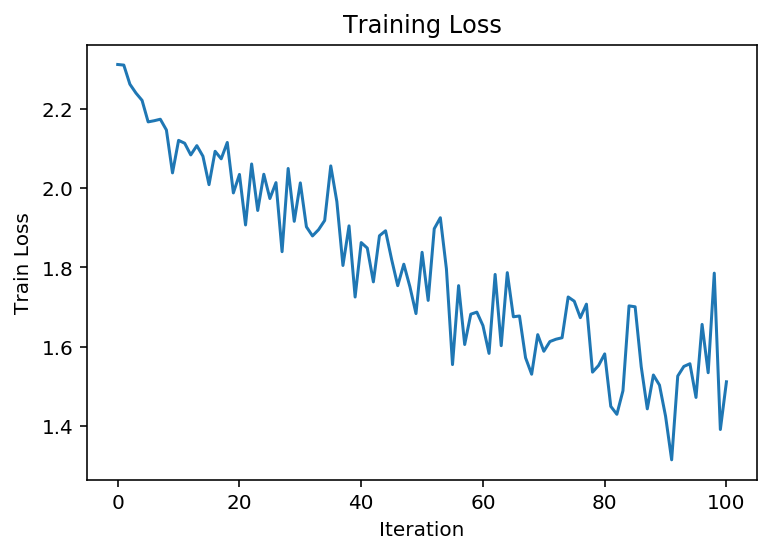

In [ ]:
run.recorder.plot_loss()

Training loss appears to be steadily decreasing. This indicates that our optimizer is working well.

### Weight Decay

We now turn our attention to enhancements that can help our model do things like avoid over fitting and learn in less epochs. The first of these techniques, weight decay, is designed to penalize (by correspondingly increasing the loss of) a model when it learns large values (either positive or negative in magnitude) for parameter weights.

The theory behind this is that when neural networks learn larger values for more of their parameter weights, they are more likely to be overfitting to the training data.

<img src="images/overfit.png" alt="Fitting vs over-fitting" width="600">

The thought is that if we can penalize networks for learning weights that are too large, the networks will be less likely to learn large weights (or in other words, will force networks to "decay" the), will correspondingly be less likely to overfit, and will thus do a better job of generalizing to unseen data once training has been completed.

The original formula for weight decay includes a hyperparameter called `wd` that practioners can adjust to control the degree to which loss is penalized as a model learns large weight magnitudes:

```python
loss_with_wd = loss + (wd/2) * (weights**2).sum()
```

However, in practice, we use a more efficient method of implementing this kind of loss penalization. The reason is that if we actually used the above formula, there may well be times that the sum of the squares of all weights is too numerically unstable to compute and add to the loss.

If, instead, we leverage the fact that the derivative of ${x}^{2}$ with respect to $x$ is just $2x$, we can make a slight alteration in the way we compute weight gradients, which will have the same effect as adjusting the loss penalty using the formula above:

```python
weight.grad += wd * weight
```
Note that this formula also describes L2 regularization, and that we should employ it only if we are also using a vanilla SGD optimizer. In their paper, [Decoupled Weight Decay Regularization](https://arxiv.org/pdf/1711.05101.pdf), Ilya Loshchilov and Frank Hutter showed that weight decay and L2 regularization are one in the same when vanilla SGD is being used. For other optimizers like Adam or RMSProp, Loshchilov and Hutter showed the L2 regularization is not the same as weight decay, and that while weight decay is useful when these optimizers are being used, L2 regularization *adds no benefits*!

Why do we care about this? Well, it just so happens that most major deep learning libraries (fastai is an exception) use the above L2 regularization formula as the default mode of weight decay when optmizers such as Adam are used! Here is the proper way to update weights via weight decay when the optimizer is Adam:

```python
weight -= lr * (weight.grad + wd*weight)
```

For our use, we'll create two distinct methods. The first we'll actually call `weight_decay()`, and it will subtract `lr*wd*weight` from the model's weights when a weight update is performed. We'll then create a method called `lr_reg()` which describes L2 regularization, which is implemented by adding `wd*weight` to the weight gradients. We'll use the former with Adam and the latter with SGD.

In [ ]:
#export
def weight_decay(weight, lr, wd, **kwargs):
    weight.data.mul(1 - lr*wd)
    return weight

weight_decay._defaults = dict(wd=0.)

In order to pass this function with in the list that goes to our `Optimizer` class' `stepper` argument, we need to give this function a `_defaults` attribute -- this ensures that our optimizer will contain a hyperparameter that has the exact same name.

In [ ]:
#export
def l2_reg(weight, lr, wd, **kwargs):
    weight.grad.data.add_(wd, weight.data)
    return weight

l2_reg._defaults = dict(wd=0.)

Notice that in the case of both `l2_reg()` and `weight_decay()` we start off with a default value of zero for the `wd` hyperparameter. We need to give our steppers a way to override this value during training, should the practitioner provide their own value for `wd`.

Why do we bother setting a default value? Doing this keeps users from having to remember to pass a `wd` argument every time they instantiate an optimizer. If they don't remember or don't want to add weight decay, then weight decay is automatically set to zero. Otherwise, whichever value the user passes to the `wd` argument is used.

The moral of the story is that taking the time to lay these extra pipes that enable flexibility gives practitioners the freedom to add their own tweaks, or not.

In [ ]:
#export
def maybe_update(steppers, defaults, get_defaults):
    for stepper in steppers:
        for key, value in get_defaults(stepper).items():
            if key not in defaults: defaults[key] = value
                
def get_defaults(stepper): return getattr(stepper, '_defaults', {})

We now reimplement our `Optimizer` class, having it first call the `maybe_update()` function to override stepper default hyperparameter values, if necessary, with ones provided by the pracitioner.

The only difference compared to the previous implementation of `Optimizer` is the addition of the line
```python
maybe_update(self.steppers, defaults, get_defaults)
```

In [ ]:
#export
class Optimizer():
    def __init__(self, param_groups, steppers, **defaults):
        
        # Get all the steppers
        self.steppers = listify(steppers)
        
        # Update stepper hyperparam defaults if necessary
        maybe_update(self.steppers, defaults, get_defaults)
        
        # param_groups could be a generator
        self.param_groups = list(param_groups) 
        # ensure param_groups is a list of lists
        if not isinstance(self.param_groups[0], list):
            self.param_groups = [self.param_groups]
        self.hyperparam_dicts = [{**defaults} for param_group in self.param_groups]
        
    def grad_params(self):
        return [(param, hyperparam_dict) for param_group, hyperparam_dict in zip(self.param_groups, self.hyperparam_dicts)
               for param in param_group if param.grad is not None]
    
    def zero_grad(self):
        for param, hyperparam_dict in self.grad_params():
            param.grad.detach_()
            param.grad.zero_()
        
    def step(self):
        for param, hyperparam_dict in self.grad_params():
            apply_functions(param, self.steppers, **hyperparam_dict)

Here's a vanilla SGD optimizer. Notice that it contains both a weight decay stepper, and a SGD stepper, but that a `wd` value isn't passed to the weight decay stepper, leaving weight decay turned off by default.

In [ ]:
#export
sgd_opt = partial(Optimizer, steppers=[weight_decay, sgd_step])

Let's doublecheck that stepper default hyperparameter values are properly being overridden when we intend to do so:

In [ ]:
learn, run = get_learn_run(n_outs, data, 0.4, conv_layer, cbs=callback_funcs, opt_func=sgd_opt)

In [ ]:
# Test that default wd & lr are used when not overridden by user
model = learn.model
opt = sgd_opt(model.parameters(), lr=0.1)
test_eq(opt.hyperparam_dicts[0]['wd'], 0.)
test_eq(opt.hyperparam_dicts[0]['lr'], 0.1)

In [ ]:
# Now test that new wd value is used when default is overridden, 
# and also that default lr value is still used as well.
opt = sgd_opt(model.parameters(), lr=0.1, wd=1e-4)
test_eq(opt.hyperparam_dicts[0]['wd'], 1e-4)
test_eq(opt.hyperparam_dicts[0]['lr'], 0.1)

Now let's train on Imagenette for one epoch, using SGD with a weight decay of `0.1`:

In [ ]:
callback_funcs = [partial(AvgStatsCallback, accuracy), CudaCallback]
learn, run = get_learn_run(n_outs, data, lr=3e-1, layer=conv_layer, 
                           cbs=callback_funcs, opt_func=partial(sgd_opt, wd=0.01))

In [ ]:
run.fit(1, learn)

train: [1.7625467150418799, tensor(0.3913, device='cuda:0')]
valid: [2.009087158203125, tensor(0.3640, device='cuda:0')]


#### Weight decay and batchnorm

Before we move on from weight decay, I should mention that my above description and exploration of weight decay assumes a world where batchnorm layers are not used. When batchnorm is used, it becomes less clear that weight decay, even with a SGD optimizer, is the same as L2 regularization.

This is because with batchnorm, whatever adjustments we make to weight gradients, and thus to the weights when performing weight decay, is then immediately normalized away when we apply batchnorm. In other words, whatever regularization we accomplish with weight decay we undo with batchnorm.

Nonetheless, practitioners would likely respond to this assertion by countering that adjustments to a model's the weight decay hyperparameter affects the model's performance, even in a network with batchnorm layers.

This naturally leads us to the question: if weight decay isn't regularizing when used in conjunction with batchnorm layers, what is it doing that affects a model's performance? There are three papers that have explored this:

1. [L2 Regularization versus Batch and Weight Normalization](https://arxiv.org/abs/1706.05350)
2. [Norm matters: efficient and accurate normalization schemes in deep networks](https://arxiv.org/abs/1803.01814)
3. [Three Mechanisms of Weight Decay Regularization](https://arxiv.org/abs/1810.12281)

There is undoubtedly still room for more study of this phenomenon. During the daily study group [Jeremy](https://twitter.com/jeremyphoward) posited that it might well be the case that shrinking the learning rate could be an alternate way to produce the same effect that is seen when weight decay is added to a network with batchnorm layers:

*"...one thing that doesn't change is that even with batchnorm your gradients are smaller by whatever factor you used for your weight decay multiplier. This is essentially the same as having a learning rate that has been decreased by that same magnitude."*

### Momentum

When I previously [looked at momentum](https://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part1_v3/blob/master/lesson2-sgd-my-reimplementation-with-momentum.ipynb?flush_cache=true) in back part I of the fastai course, I observed that momentum accelerates gradient descent, which can help nets to train sooner. 

It does this by combining a decaying average of the previous gradients with the current gradient, and then updating the model weights.

What's happening, conceptually speaking, is that if the model's optimizer has recently been updating weights using gradients that all have the same direction, relative to the surface of the loss function, momentum helps the model be more confident that it should continue and proceed to take even larger subsequent steps in the same direction. 

Conversely, if recent weight updates have been using gradients from opposite directions, momentum helps the model to hesitate, and make smaller steps in whatever subsequent directions it proceeds.

Implementing momentum as a stepper function, similar to what we did with weight decay, will allow us to use it with our optimizer. However, we first need to revise our `Optimizer` class so that it can store the moving average of gradients and use this average at each iteration to perform the weight update step.

The first bit of work that must be done in order to accomplish this is to introduce a `Statistic()` object that contains scaffolding that will allows classes that inherit from this class to implement methods that:
1. Return the statistic's initial state (e.g. a tensor of 0 for the moving average of gradients). 
2. Updates the statistic's state for each new gradient value.
3. Set the statistic's default value (e.g. the value of the momentum, or β parameter, that the user chooses).

In [ ]:
#export
class Statistic():
    _defaults = {}
    def init_state(self, weight): raise NotImplementedError
    def update(self, weight, state, **kwargs): raise NotImplementedError

For example, if we want to implement standard momentum, we can implement an `AverageGradients` statistic that manages updates to the decaying average of previous gradients that is calculated right before each momentum weight update step is performed:

In [ ]:
class AverageGradients(Statistic):
    _defaults = dict(mom = 0.9)
    
    def init_state(self, weight): return {'grad_avg': torch.zeros_like(weight.grad.data)}
    def update(self, weight, state, mom, **kwargs):
        state['grad_avg'].mul_(mom).add_(weight.grad.data)
        return state

Now we create `StatefulOptimizer`, which is a revision of `Optimizer` that can get and save the most recent state for all weight params that need to be updated during a single step (the gradient params).

Once more: why does saving state matter? Stepper algorithms like momentum need to be able to access gradients' running averages in order to be able to properly update gradients at a given step. The running average itself must also be updated after each step.

In [ ]:
#export
class StatefulOptimizer(Optimizer):
    def __init__(self, param_groups, steppers, statistics=None, **defaults):
        self.statistics = listify(statistics)
        maybe_update(self.statistics, defaults, get_defaults)
        super().__init__(param_groups, steppers, **defaults)
        self.state = {}
        
    def step(self):
        for param, hyperparam_dict in self.grad_params():
            if param not in self.state:
                # Create a state for the param and call all statistics 
                # in order to initialize it.
                self.state[param] = {}
                maybe_update(self.statistics, self.state[param], lambda o: o.init_state(param))
            state = self.state[param]
            for statistic in self.statistics:
                state = statistic.update(param, state, **hyperparam_dict)
            apply_functions(param, self.steppers, **state, **hyperparam_dict)
            self.state[param] = state

Similar to the way we implemented the weight decay step, here's a function that can be used as a stepper that executes momentum weight updates:

In [ ]:
#export
def momentum_step(weight, lr, grad_avg, **kwargs):
    # The line below that uses add_ is equivalent to performing
    # the following in place: weight.data -= (lr * grad_avg)
    weight.data.add_(-lr, grad_avg)
    return weight

And similar to how we earlier constructed an SGD optimizer that used weight decay, we can now add momentum by using `StatefulOptimizer`, passing an `AverageGradient()` object as a statistic, and including `momentum_step` in our list of steppers. We are using the default value of the momentum hyperparamter (the β parameter) of `0.9` that we defined above in our `AverageGradients` class.

In [ ]:
sgd_mom_and_wd_opt = partial(StatefulOptimizer, steppers = [momentum_step, weight_decay],
                      statistics=AverageGradients(), wd=0.01)

In [ ]:
learn, run = get_learn_run(n_outs, data, 0.3, conv_layer, cbs=callback_funcs, opt_func=sgd_mom_and_wd_opt)

In [ ]:
run.fit(1, learn)

train: [1.7702842346731038, tensor(0.3898, device='cuda:0')]
valid: [1.6903212890625, tensor(0.4300, device='cuda:0')]


#### Momentum Experiments
Let's now take a short time out and go through a series of visualizations that refreshes and gives further insight into both what momentum does and how to choose an adequate value for the momentum hyperparameter β. We'll also compare and contrast various approaches to implementing momentum.

In [ ]:
# Create some random points
x = torch.linspace(-4, 4, 200)
y = torch.randn(200) + 0.3

# Different values we could use for the momentum hyperparameter β
βs = [0.5, 0.7, 0.9, 0.99]

In [ ]:
# A method to plot momentum for different values of β
def plot_mom(mom_func):
    _, axs = plt.subplots(2, 2, figsize=(12, 8))
    for β, ax in zip(βs, axs.flatten()):
        ax.plot(y.detach().cpu().numpy(), linestyle='None', marker = '.')
        avg, result = None, []
        for i, y_i in enumerate(y):
            avg, weight_grad = mom_func(avg, β, y_i, i)
            result.append(weight_grad)
        ax.plot(result, color='red')
        ax.set_title(f'β = {β}')

`mom1()` is the standard way of implementing momentum:

In [ ]:
def mom1(avg, β, y_i, i):
    if avg is None: avg = y_i
    avg = β * avg + y_i
    return avg, avg

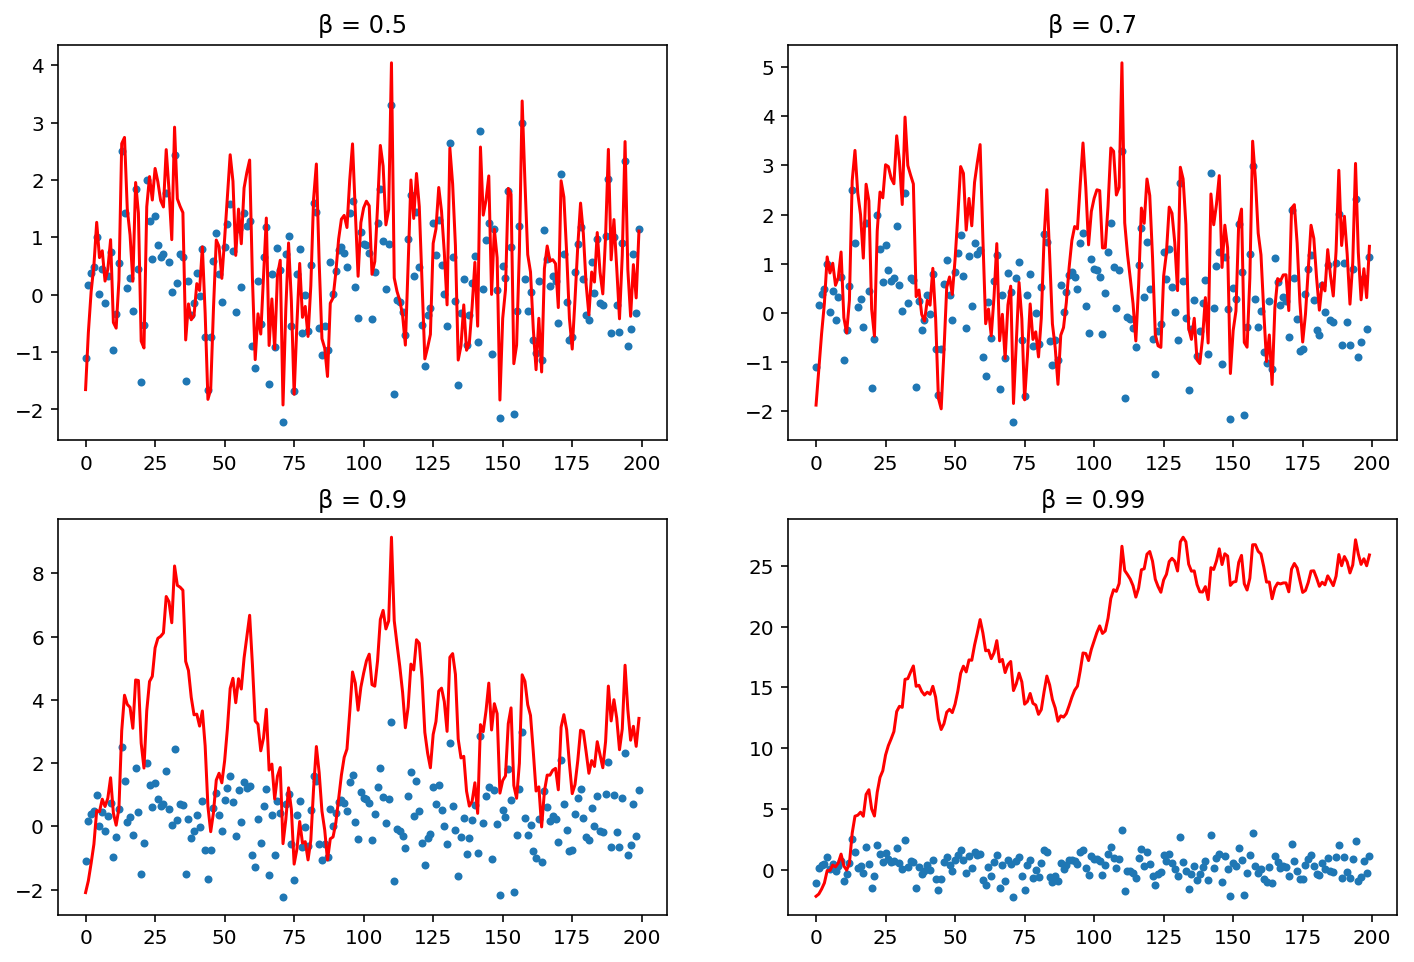

In [ ]:
plot_mom(mom1)

The idea is that momentum will help our model traverse the loss landscape and find the minimum that would have been found without momentum, but in less time. In other words, a well chosen momentum hyperparameter value will help our optimizer make smart shortcuts.

If, however, we pick a value for β that is too large, we run the risk of having our optimizer increasingly pay too-small an amount attention to the output loss function. There is a snowball effect of poor decisions spurring even poorer decisions. Our optimizer, rather than compensating for a poorly chosen weight update by adjusting parameter weights in the opposite direction the next time around, instead decides to move an even larger distance in the same wrong direction as before. In essence, the optimizer has developed a nasty case of near-sighted hubris, in that it bases its rationale for each subsequent poorly chosen weight update on previous poorly chosen weight updates. Our optimizer is paying too much attention to previous iterations' weight gradients. This phenomenon, while slightly apparent in the above plot for where β is 0.9, is very noticeable in the graph for a β of 0.99.

On the other side of the same coin, if we pick too small a value for β, we run the risk of updating weights in a way that over-responds to each fluctuation in the loss landscape and ignores any general patterns: one moment we're making weights too big, and the next we're making weights too small -- all because we're not paying enough attention to previous iterations' gradients. This is visible in the above plot where β is 0.5. In this case, we're not applying sufficient momentum necessary for our optimizer to begin taking smart shortcuts as it traverses down the surface of the loss function.

Two takeaways from the above experiment are readily apparent:
1. Picking the right value for the momentum hyperparameter, β, is really important, especially for jagged loss landscapes.
2. Momentum, as traditionally implemented, is not terribly forgiving when sub-par values for β are chosen, at least when the loss function's landscape is bumpy (the data is noisy).

This should lead us to wonder: is there a better way to implement momentum that's a bit more forgiving?

Thankfully, there is! Instead of taking a simple running average of previous gradients, taking an exponentially weighted moving average of previous gradients can help smooth out noisy data. Below we re-implement momentum using this approach. The key difference as far as implementation is concerned is that there is now a `(1 - β)` dampening factor in front of the most recent gradient.

In [ ]:
#export
def linear_combination(value1, value2, β):
    return β * value1 + (1 - β) * value2

In [ ]:
def mom2(avg, β, y_i, i):
    if avg is None: avg = y_i
    avg = linear_combination(avg, y_i, β)
    return avg, avg

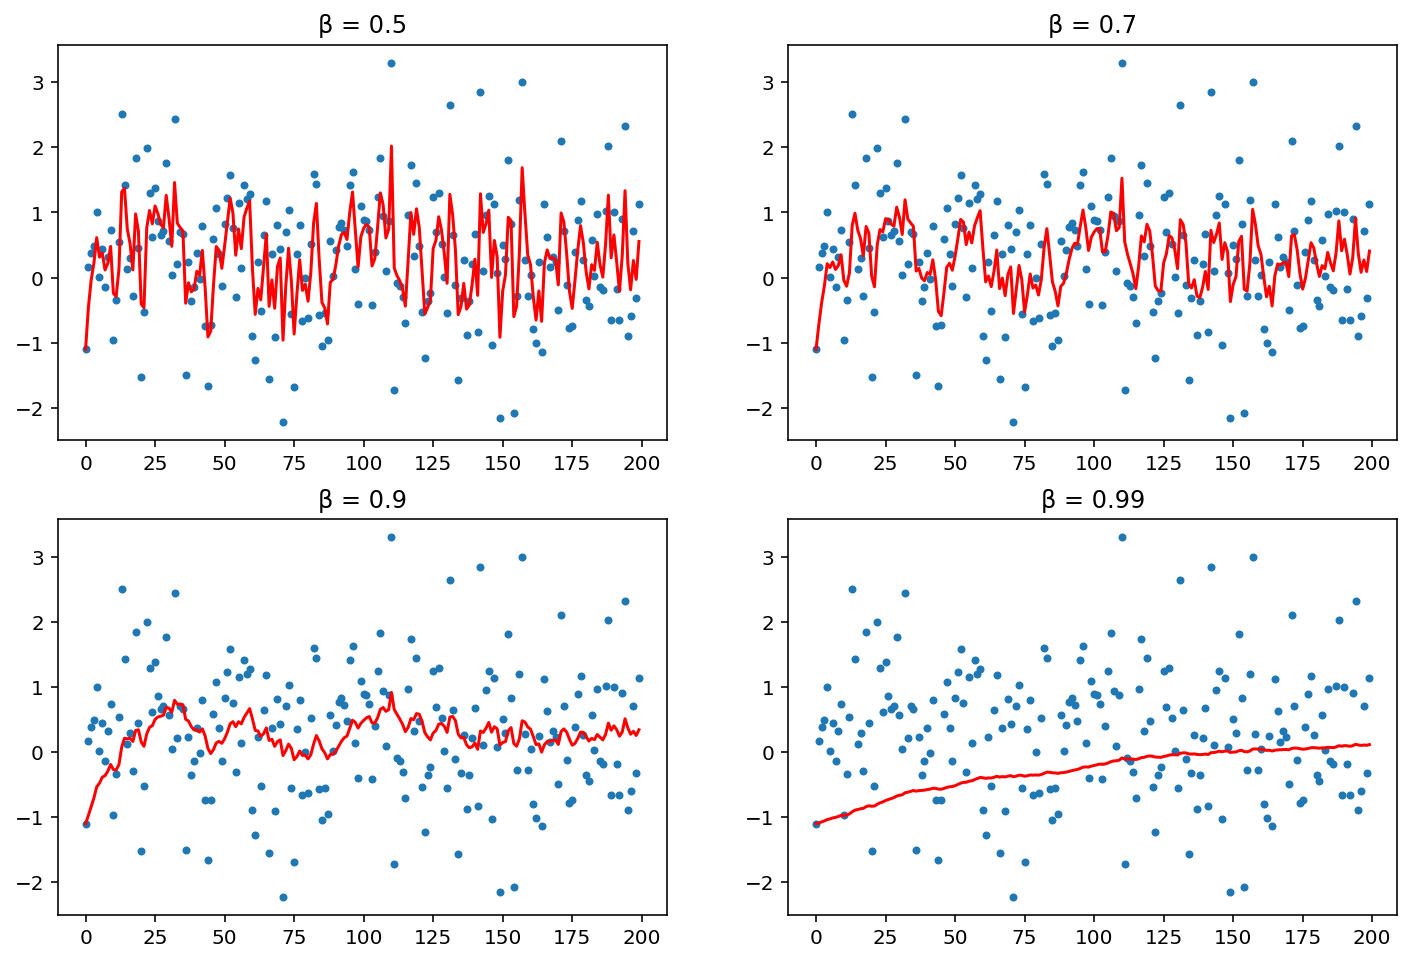

In [ ]:
plot_mom(mom2)

The results for our synthetic noisy data experiment are much more encouraging this time around. Lower values of β don't bounce around from update-to-update as much as they previously did. Similarly, high values of β generalize quite adequately to our completely random data.

Let's run one more experiment, this time using data that fits a pattern, and see if with high values of β, our `mom2()` momentum implementation is still able to generalize appropriately. We'll also throw one monkey wrench into the process, This is intended to simulate what often happens when training neural networks, which is that the first couple of weight updates aren't in-line with the pattern of the data. The test here is to see if our momentum implementation can pay enough attention to previous gradients to speed up training, but can also pay little enough attention such that it doesn't get thrown off by early weight updates that are essentially random moves.

In [ ]:
y = 1 - (x/3)**2 + torch.randn(200)*0.1
y[0] = 0.5

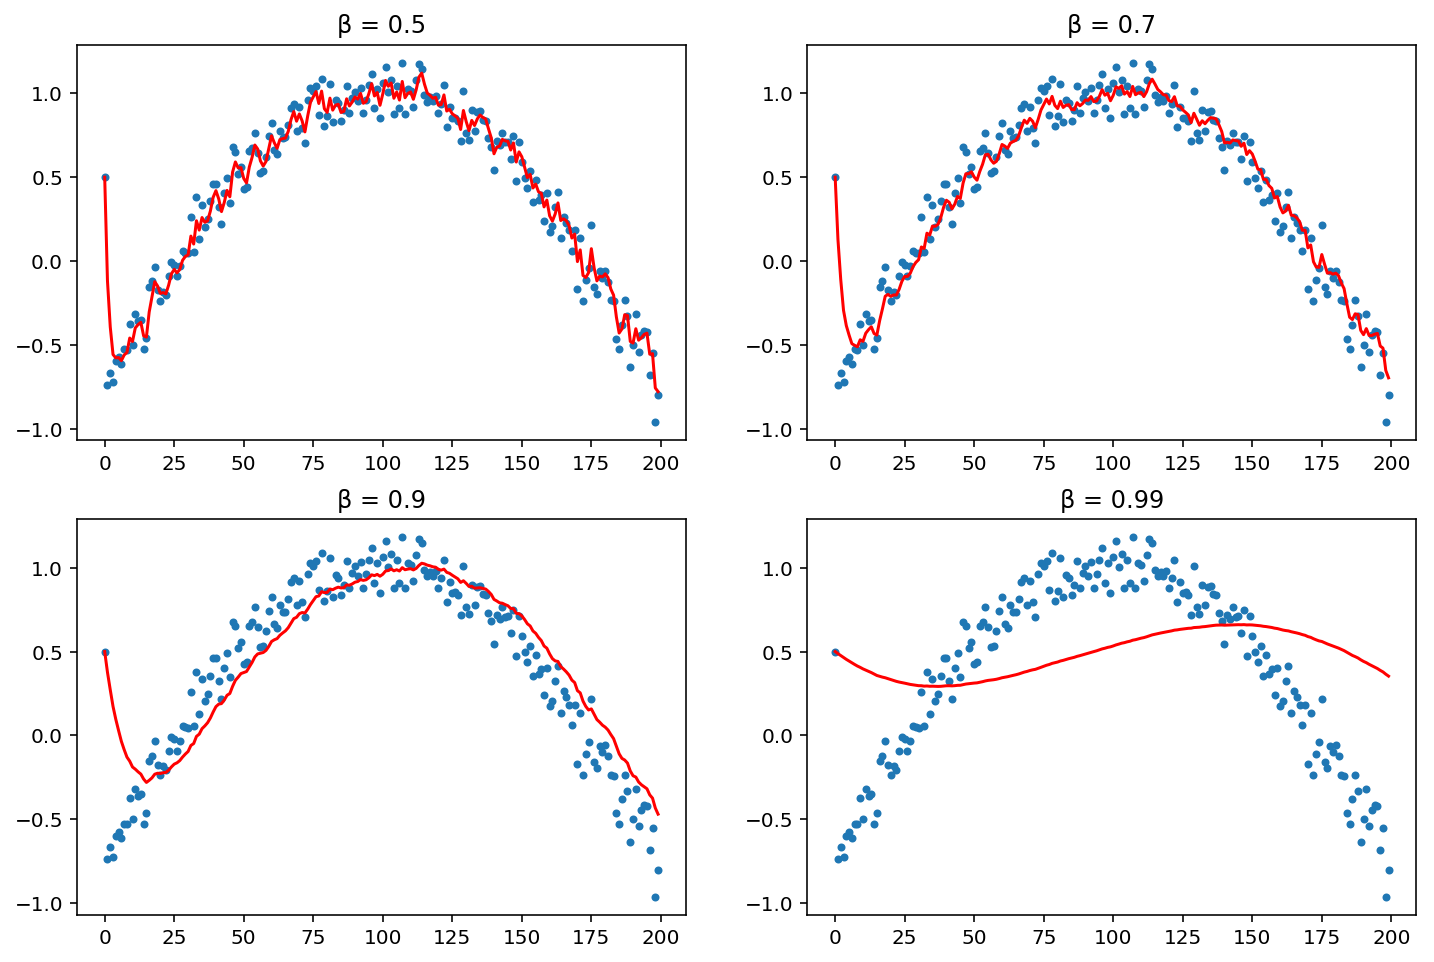

In [ ]:
plot_mom(mom2)

Unfortately, even our improved second attempt at implementing momentum, which uses an exponentially weighted moving average, is far too-greatly influenced by initial random values when β is sufficiently large.

So now the question is: can we do anything to correct for this? 

The good news, once again, is that we can! Just prior to using it to update weights, we can divide our exponentially weighted moving average by a debiasing term, which will correct for the random/unhelpful information contained in the model's gradients computed during the first mini-batch of training. 

This debias term is just $1 - β^{i + 1}$, and it is the sum of the coefficients of the exponentially weighted moving average of previous gradients from all iterations up to and including iteration $i-1$. 

More specifically, recall that at iteration $i$ our moving average is: $\begin{align*}
avg_{i} &= (1-\beta)\ \beta^{i}\ m_{0} + (1-\beta)\ \beta^{i-1}\ m_{1} + \cdots + (1-\beta)\ \beta^{2}\ m_{i-2} + (1-\beta)\ \beta\  m_{i-1} + (1-\beta)\ m_{i}
\end{align*}$

The sum of coefficients used in the above average computation is: $\begin{align*}
S &=(1-\beta)\ \beta^{i} + (1-\beta)\ \beta^{i-1} + \cdots + (1-\beta)\ \beta^{2} + (1-\beta)\ \beta + (1-\beta) \\
&= (\beta^{i} - \beta^{i+1}) + (\beta^{i-1} - \beta^{i}) + \cdots + (\beta^{2} - \beta^{3}) + (\beta - \beta^{2}) + (1-\beta) \\
&= 1 - \beta^{i+1}
\end{align*}$

So why do we care about summing up all the coefficients? And why is this sum a sensible way of debiasing the moving average so we can then immediately use it to update weights? The reason is that dividing by this debias term turns our moving average into a true average because all the coefficients that we had used to compute the moving average sum up to 1.

Using this debiasing term can be thought of as a precautionary last step, where we tell our moving average to stop paying so much attention to early iteration gradients, and listen to all gradients equally. It's sort of a neat trick that lets us get the best of both worlds:
* We keep calculating an exponentially weighted moving average from iteration to iteration, and this helps our optimizer to not be thrown off by a bumpy loss function (making the mistake that `mom1()` made).
* While at the same time letting us momentarily transform this moving average into a standard average whenever a weight update is applied, so that early-iteration gradients are not overly paid attention to (the mistake that `mom2()` made.

Indeed, in implementing `mom3()` we can see why we architected all our previous momentum fuctions to return a tuple. Until now, the tuple contained duplicates of the moving average value. This time, however, while the tuple's first index still contains this moving average, the second index, which is the actual amount by which we will update parameter weights, contains the debiased average. We can't just return one value because we dont want our calculation of the moving average to be done using the debiased weight updates (it would cease to be a moving average if this were the case, and our optimizer would be more vulnerable to a jagged loss surface).

In [ ]:
def mom3(avg, β, y_i, i):
    if avg is None: avg = 0
    avg = linear_combination(avg, y_i, β)
    # First value of returned tuple used ongoing computation of moving avg.
    # Second value is used to update weights.
    return avg, avg/(1 - β**(i+1))

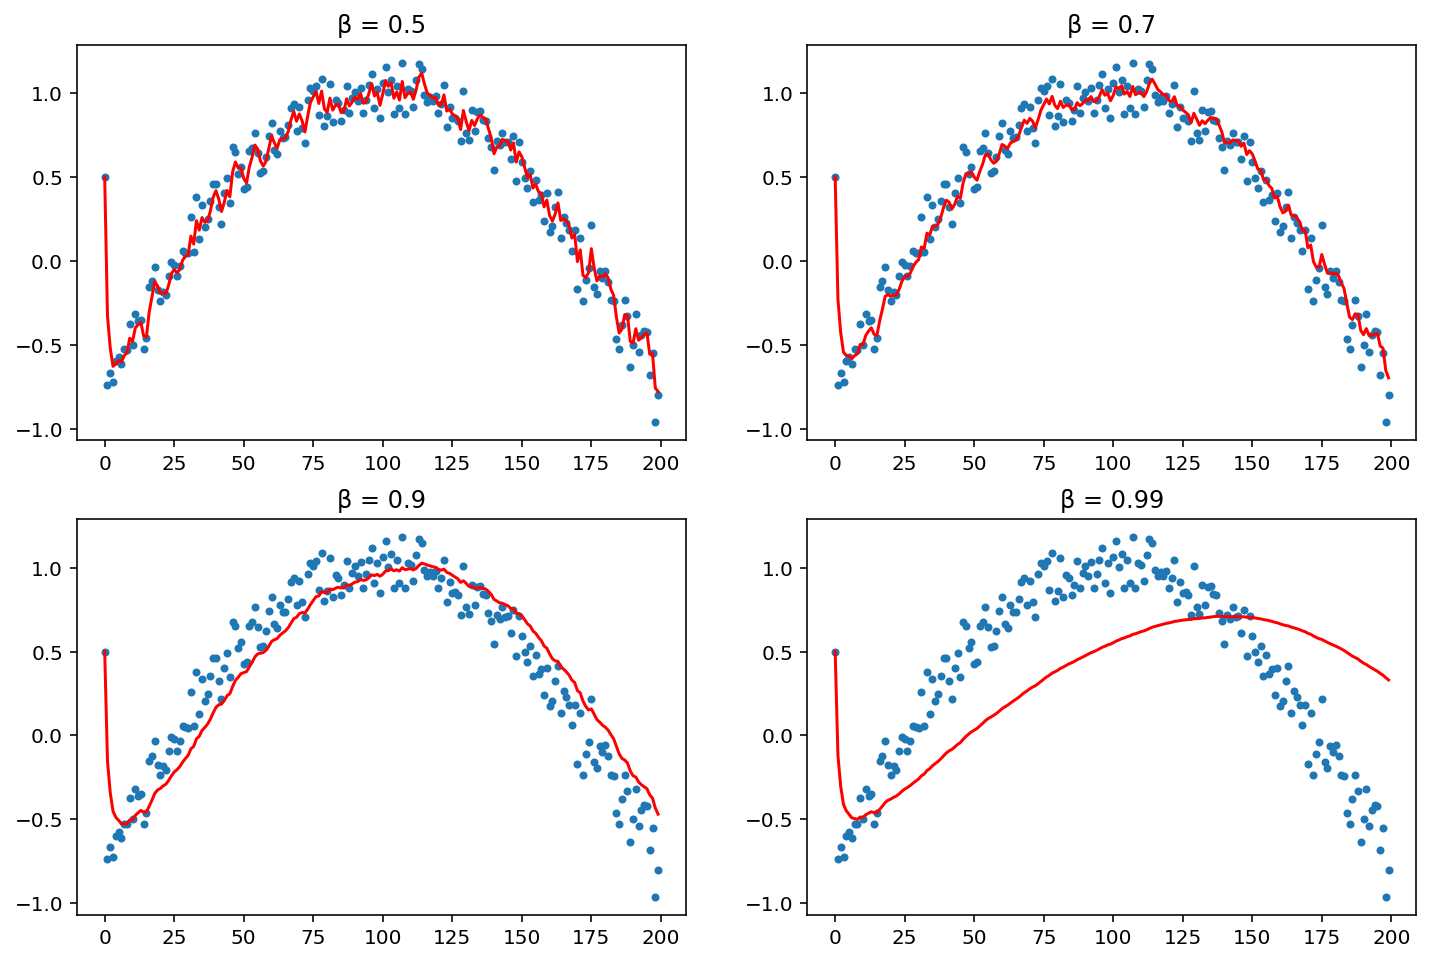

In [ ]:
plot_mom(mom3)

We see that debiasing the moving average before using it to update weights indeed helps our optimizer to pay less attention to early weight gradients, even at high values of β!

### Adam

The above experiments all presumed that it was a vanilla stochastic gradient descent optimizer that was being utilized, for whom momentum is usually a nice add-on. Now let's turn our attention to implementing the [Adam optimizer](https://arxiv.org/abs/1412.6980), which always employs momentum as a core component of its algorithm. There are four core building blocks that we need to first create in order to implement Adam:
1. A decaying *and dampened* running average, $m_{i}$, of previous gradients. Specifically, $m_{i} = \beta_{1}*m_{i-1} + (1-\beta_{1})*g_{i}$, where $g_{i}$ is the gradient computed at the current iteration $i$, $\beta_{1}$ is the momentum decay rate, and $m_{0}$ is initialized to zero. We can just reimplement the `AverageGradients` class that we wrote earlier, and this time modify it to include the dampening factor $(1-\beta_{1})$.
2. A decaying and dampened running average, $v_{i}$, of previous ***squared*** gradients. The computation is the same as step 1. above, except we use a different decay rate $\beta_{2}$, and instead of using the gradient $g_{i}$, we use its square, $g_{i}^{2}$.
3. A simple step-count of the number of steps completed during training. In other words, we want to keep track of the count $i_{\text{th}}$ iteration of training (this count *does not* reset after each mini-batch).
4. A debiasing method that will be used to debias the decaying, dampened averages computed in steps 1. and 2. The motivation for debiasing is the same as when we implemented `mom3()` earlier -- we want to transform our weighted averages into standard averages right before applying weight updates, so that the gradient values from earlier iterations won't overly influence ongoing weight updates.

In [ ]:
#export

# Adam part 1: Update the decaying, dampened average of 
# previous gradients.
class AverageGradients(Statistic):
    _defaults = dict(mom = 0.9)
    def __init__(self, dampening:bool = True): self.dampening = dampening
    def init_state(self, weight): return {'grad_avg': torch.zeros_like(weight.grad.data)}
    def update(self, weight, state, mom, **kwargs):
        state['mom_damp'] = 1 - mom if self.dampening else 1.
        state['grad_avg'].mul_(mom).add_(state['mom_damp'], weight.grad.data)
        return state
    
# Adam part 2: Update the decaying, dampened average of 
# previous squared gradients.
class AverageSquaredGradients(Statistic):
    _defaults = dict(sqr_mom = 0.99)
    def __init__(self, dampening:bool = True): self.dampening = dampening
    def init_state(self, weight): return {'sqr_grad_avg': torch.zeros_like(weight.grad.data)}
    def update(self, weight, state, sqr_mom, **kwargs):
        state['sqr_mom_damp'] = 1 - sqr_mom if self.dampening else 1.
        # The addcmul_ operation performs an element-wise multiplication 
        # of weight.grad.data and weight.grad.data, and then multiplies 
        # this product by state['sqr_mom_damp']. This result is then 
        # added to the result of state['sqr_grad_avg'].mul_(sqr_mom).
        state['sqr_grad_avg'].mul_(sqr_mom).addcmul_(state['sqr_mom_damp'], weight.grad.data, weight.grad.data)
        return state
    
# Adam part 3: Keep and update a count of the number of training 
# iterations performed so far during all of training (across all 
# mini-batches).
class StepCount(Statistic):
    def init_state(self, weight): return {'step': 0}
    def update(self, weight, state, **kwargs):
        state['step'] += 1
        return state

We now need only implement a simple method to support debiasing. If we assume that a dampening term will always be used, we only would need the debiasing method to return `(1 - mom**step)`. Debias terms would then be generated for and divided into the running average gradients (and squared gradients) during the Adam step.

However, we'd like to also be able to debias these running averages even when dampening isn't used. In order to accomplish this the method actually returns `damp * (1 - mom**step) / (1 - mom)`. Recall that `damp = 1 - mom` if we use dampening and if we don't use dampening, `damp = 1`. So if dampening is being used, `damp` and `(1 - mom)` cancel out and we return `(1 - mom**step)`.

Now if we're not using dampening, we must divide the `(1 - mom**step)` debiaser by `(1 - mom)`. Why? Recall that when dampening is used, at iteration $i$ our moving average is: 

$\begin{align*}
avg_{i} &= (1-\beta)\ \beta^{i}\ m_{0} + (1-\beta)\ \beta^{i-1}\ m_{1} + \cdots + (1-\beta)\ \beta^{2}\ m_{i-2} + (1-\beta)\ \beta\  m_{i-1} + (1-\beta)\ m_{i}
\end{align*}$

And the sum of coefficients is: 

$\begin{align*}
S &=(1-\beta)\ \beta^{i} + (1-\beta)\ \beta^{i-1} + \cdots + (1-\beta)\ \beta^{2} + (1-\beta)\ \beta + (1-\beta) \\
&= (\beta^{i} - \beta^{i+1}) + (\beta^{i-1} - \beta^{i}) + \cdots + (\beta^{2} - \beta^{3}) + (\beta - \beta^{2}) + (1-\beta) \\
&= 1 - \beta^{i+1}
\end{align*}$

Which was how we got our debias term when dampening is used. But if we're not using dampening, at iteration $i$ our moving average is just: 

$\begin{align*}
avg_{i} &= \ \beta^{i}\ m_{0} + \ \beta^{i-1}\ m_{1} + \cdots +  \beta^{2}\ v_{i-2} +  \beta\  m_{i-1} +  m_{i}
\end{align*}$

The $(1-\beta)$ coefficient is missing from each term of the running average, so if we want to still debias by $(1 - \beta^{i+1})$, we need to ensure the running average is first multiplied by $(1-\beta)$. Placing $(1-\beta)$ in the denominator of the debias term returned by the `get_debiaser()` method below will ensure that this happens.

In [ ]:
#export

# Adam part 4: General method that can be used to get debias terms for 
# the decaying, dampened average of previous gradients, as well as the 
# decaying, dampened average of previous squared gradients.
def get_debiaser(mom, damp, step): return damp * (1 - mom**step) / (1 - mom)

With the above key components fully implemented we can turn our attention to defining the actual Adam stepper. All this stepper needs to accomplish (assuming we're using dampening) is:

1. Debias $m_{i}$: $$\hat m_{i} = \frac{m_{i}}{(1 - \beta_{1}^{i})}$$
2. Debias $v_{i}$: $$\hat v_{i} = \frac{v_{i}}{(1 - \beta_{1}^{i})}$$
3. Update weights $\theta$ at timestep $i$ (learning rate is denoted by $\alpha$, $\epsilon$ is a small constant for which the Adam paper recommends a value of `1e-8` but we'll use `1e-5`):  $$\theta_{i} = \theta_{i-1} - \alpha * \frac{\hat m_{i}}{(\sqrt{\hat v_{i}} + \epsilon)}$$

In [ ]:
#export 
def adam_step(weight, lr, mom, mom_damp, step, sqr_mom, 
              sqr_mom_damp, grad_avg, sqr_grad_avg, eps, **kwargs):
    debias1 = get_debiaser(mom, mom_damp, step)
    debias2 = get_debiaser(sqr_mom, sqr_mom_damp, step)
    # The addcdiv operation performs the element-wise division of 
    # grad_avg and ((sqr_grad_avg/debias2).sqrt() + eps). This result 
    # is then multiplied by -lr/debias1, whose result is finally 
    # added to weight.data.
    weight.data.addcdiv_(-lr/debias1, grad_avg, (sqr_grad_avg/debias2).sqrt() + eps)
    return weight

adam_step._defaults = dict(eps = 1e-5)

In [ ]:
#export
def adam_opt(extra_steppers=None, **kwargs): # Allow for inclusion of any other steppers
    return partial(StatefulOptimizer, 
                   steppers=[adam_step, weight_decay] + listify(extra_steppers), 
                   statistics=[AverageGradients(), AverageSquaredGradients(), StepCount()], 
                   **kwargs)

In [ ]:
learn, run = get_learn_run(n_outs, data, 0.001, conv_layer, 
                           cbs=callback_funcs, opt_func=adam_opt())

In [ ]:
run.fit(3, learn)

train: [1.7446688200422678, tensor(0.4011, device='cuda:0')]
valid: [1.3755030517578124, tensor(0.5320, device='cuda:0')]
train: [1.2324917052020319, tensor(0.5980, device='cuda:0')]
valid: [1.0596505126953124, tensor(0.6560, device='cuda:0')]
train: [0.9359694158862649, tensor(0.6981, device='cuda:0')]
valid: [0.9687302856445312, tensor(0.6940, device='cuda:0')]


### LAMB

The beauty of breaking our Adam optimizer into the above four core modules is that we can recycle them to more easily implement other optimizers from scratch. For instance, the [LAMB optimizer recently proposed by You, Li, et. al.](https://arxiv.org/abs/1904.00962), which was used to pretrain the [BERT-Large model](https://arxiv.org/abs/1810.04805) in only 85,999 iterations (Devlin used 1 million iterations in the original BERT paper), happens to have some of the same pieces as Adam:

1. Uses the same running averages of gradients and squared gradients that Adam uses:
$$m_{i} = \beta_{1}m_{i-1} + (1 - \beta_{1})*g_{i}$$
$$v_{i} = \beta_{2}v_{i-1} + (1 - \beta_{2})*g_{i}^2$$
2. Then, $m_{i}$ and $v_{i}$ are both debiased in the same way as Adam: $$\hat m_{i} = \frac{m_{i}}{(1 - \beta_{1}^{i})}$$
$$\hat v_{i} = \frac{v_{i}}{(1 - \beta_{1}^{i})}$$
3. The first difference between LAMB and Adam is that the weight update value, $s_{i}$ also includes a weight decay term, $\lambda\theta_{i-1}$, which is some portion, $\lambda$, of the most recent iteration's parameter weights:
$$s_{i} = \frac{\hat m_{i}}{(\sqrt{\hat v_{i}} + \epsilon)} + \lambda\theta_{i-1}$$
4. The second difference between LAMB and Adam is that the learning rate, or step size, $\alpha$ is scaled by $\frac{r_{1}}{r_{2}}$, where:
$$r_{1} = \|\theta_{i-1}\|_{2}$$
$$r_{2} = \|s_{i} \|_{2}$$

   and thus,

$$\alpha = \alpha * \frac{r_{1}}{r_{2}}$$
5. Then the new weights $\theta_{i}$ after the weight update are:
$$\theta_{i} = \theta_{i-1} - \alpha * s_{i}$$

Indeed, we can essentially implement a LAMB stepper using most of the parts of our Adam stepper, and adding in the necessary $r_{1}$, $r_{2}$, and weight decay components:

In [ ]:
def lamb_step(weight, lr, mom, mom_damp, step, sqr_mom, 
              sqr_mom_damp, grad_avg, sqr_grad_avg, eps, wd, **kwargs):
    debias1 = get_debiaser(mom, mom_damp, step)
    debias2 = get_debiaser(sqr_mom, sqr_mom_damp, step)
    r1 = weight.data.pow(2).mean().sqrt()
    step = ((grad_avg/debias1) / ((sqr_grad_avg/debias2).sqrt() + eps)) + wd*weight.data
    r2 = step.pow(2).mean().sqrt()
    weight.data.add_(-lr * min(r1/r2, 10), step)
    return weight

lamb_step._defaults = dict(eps = 1e-6, wd=1e-4)

In [ ]:
def lamb_opt(**kwargs):
    return partial(StatefulOptimizer, 
                   steppers = [lamb_step], 
                   statistics = [AverageGradients(), AverageSquaredGradients(), StepCount()],
                   **kwargs)

In [ ]:
learn, run = get_learn_run(n_outs, data, 0.003, conv_layer, 
                           cbs=callback_funcs, opt_func=lamb_opt())

In [ ]:
run.fit(3, learn)

train: [1.8372576089169381, tensor(0.3643, device='cuda:0')]
valid: [1.501192138671875, tensor(0.4800, device='cuda:0')]
train: [1.3154054514212037, tensor(0.5684, device='cuda:0')]
valid: [1.277969482421875, tensor(0.5840, device='cuda:0')]
train: [1.030967119517799, tensor(0.6681, device='cuda:0')]
valid: [1.27834130859375, tensor(0.5880, device='cuda:0')]


Here are some other optimizers that have been recently proposed:
* [Large Batch Training of Convolutional Networks](https://arxiv.org/abs/1708.03888) (LARS uses weight statistics in addition to gradient statistics.)
* [Adafactor: Adaptive Learning Rates with Sublinear Memory Cost](https://arxiv.org/abs/1804.04235) (Adafactor combines statistics over several sets of axes.)
* [Adaptive Gradient Methods with Dynamic Bound of Learning Rate](https://arxiv.org/abs/1902.09843)

### Getting rid of the `Runner` class

Up until now, everytime we've trained a model, we've had to use the `get_learn_run()` function to get both a `Learner()` object that stores our data, loss function, model, and optimizer, as well as a `Runner()` object handles all aspects of the training loop, such as callbacks, loading data for each minibatch, displaying metrics, and performing inference.

Initially implementing these two classes as distinct, separate entities gave us the space to drill down on each and every component that must be implemented in order to train and use deep learning models. In practice, however, I find I often can't easily remember what class handles what. For instance, `Learner()` stores the datasets and dataloaders, but once data is loaded for a minibatch, the inputs and labels for that batch are inside `Runner()`.

Moreover, given that `Learner()` and `Runner()` are always both created (with `get_learn_run()`) and used (`run.fit(learn)`) together, it would likely make for a lighter mental load on pracitioners to have the `Learner` class also handle all aspects of running the training loop. Therefore, we now reimplemement `Learner`, including in it all the methods necessary to run a training loop, such as `fit()`, as well as the ability to receive and execute callbacks at any point during training.

In [ ]:
#export

# A function to get all of a model's parameter groups.
def param_getter(model): return model.parameters()

class Learner():
    def __init__(self, model, data, loss_func, opt_func=sgd_opt, lr=3e-4, 
                 splitter=param_getter, callback_funcs=None):
        self.model, self.data, self.loss_func, self.opt_func, self.lr, self.splitter = model, data, loss_func, opt_func, lr, splitter
        self.in_train = False
        self.opt = None
        self.logger = print
        
        self.callbacks = []
        self.add_callback(TrainEvalCallback())
        self.add_callbacks(callback_func() for callback_func in listify(callback_funcs))
        
    def add_callbacks(self, callbacks):
        for callback in listify(callbacks): self.add_callback(callback)
        
    def add_callback(self, callback):
        callback.set_runner(self)
        setattr(self, callback.name, callback)
        self.callbacks.append(callback)
        
    def remove_callbacks(self, callbacks):
        for callback in listify(callbacks): self.callbacks.remove(callback)
            
    def one_batch(self, i, xb, yb):
        try:
            self.iter = i
            self.xb, self.yb = xb, yb
            self('begin_batch')
            self.pred = self.model(self.xb) 
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException:
            self('after_cancel_batch')
        finally:
            self('after_batch')
            
    def all_batches(self):
        self.iters = len(self.dl)
        try:
            for i, (xb, yb) in enumerate(self.dl): self.one_batch(i, xb, yb)
        except CancelEpochException: self('after_cancel_epoch')
            
    def do_begin_fit(self, epochs):
        self.epochs = epochs
        self.loss = tensor(0.)
        self('begin_fit')
        
    def do_begin_epoch(self, epoch):
        self.epoch = epoch
        self.dl = self.data.train_dl
        return self('begin_epoch')
    
    def fit(self, epochs, callback_funcs=None, reset_opt=False):
        # New feature: support passing callbacks directly to fit(). 
        # They are removed when fit is finished.
        self.add_callbacks(callback_funcs)
        # New feature: support creating an optimizer when fit() is 
        # called. Replaces previously existing optimizer self.opt_func.
        if reset_opt or not self.opt: 
            self.opt = self.opt_func(self.splitter(self.model), lr=self.lr)
        
        try:
            self.do_begin_fit(epochs)
            for epoch in range(epochs):
                self.do_begin_epoch(epoch)
                if not self('begin_epoch'): self.all_batches()
                
                with torch.no_grad():
                    self.dl = self.data.valid_dl
                    # If self('begin_validate') hasn't been called 
                    # by any callback, such as the TrainEvalCallback, 
                    # then proceed to generate predictions for the 
                    # entire validation set.
                    if not self('begin_validate'): self.all_batches()
                self('after_epoch')
        
        except CancelTrainException: self('after_cancel_train')
        finally: 
            self('after_fit')
            self.remove_callbacks(callback_funcs)
            
    ALL_CALLBACKS = {'begin_batch',
                     'after_pred',
                     'after_loss',
                     'after_backward',
                     'after_step',
                     'after_cancel_batch',
                     'after_batch',
                     'after_cancel_epoch',
                     'begin_fit',
                     'begin_epoch',
                     'begin_validate',
                     'after_epoch',
                     'after_cancel_train',
                     'after_fit'}
    
    def __call__(self, callback_name):
        assert callback_name in self.ALL_CALLBACKS
        for callback in sorted(self.callbacks, key = lambda x: x._order):
            callback(callback_name)

We'll also reimplement the `AvgStatsCallback`. It'll be just the same as our most recent implementation, save for the `after_epoch()` method, which use the function passed to `Learner`'s `self.logger` to display the train and validation stats. If we wanted, we could pass a function to `self.logger` that write the train/validation metrics to a file or a progress bar.

In [ ]:
#export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats, self.valid_stats = AvgStats(metrics,in_train=True), AvgStats(metrics,in_train=False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
            
    def after_epoch(self):
        self.logger(self.train_stats)
        self.logger(self.valid_stats)

In [ ]:
callback_funcs = [partial(AvgStatsCallback, accuracy),
                  CudaCallback,
                  partial(BatchTransformXCallback, norm_imagenette)]

We can replace `get_learn_run()` with a `get_learn()` method that'll return our new and improved, one-stop-shop `Learner()` object.

In [ ]:
#export
def get_learner(n_outs, data, lr, layer, loss_func=F.cross_entropy,
                callback_funcs=None, opt_func=sgd_opt, **kwargs):
    model = get_cnn_model(data, n_outs, layer, **kwargs)
    init_cnn(model)
    return Learner(model, data, loss_func, lr=lr, 
                   callback_funcs=callback_funcs, opt_func=opt_func)

In [ ]:
learn = get_learner(n_outs, data, 0.4, conv_layer, callback_funcs=callback_funcs)

Let's make sure the new `Learner` class is working properly:

In [ ]:
%time learn.fit(1)

train: [1.7802634401174966, tensor(0.3787, device='cuda:0')]
valid: [1.74248291015625, tensor(0.4040, device='cuda:0')]
CPU times: user 8.43 s, sys: 2.85 s, total: 11.3 s
Wall time: 12.7 s


Let's also make sure that our `Recorder` and `ParamScheduler` callbacks still work with the new `Learner`:

In [ ]:
callback_funcs += [Recorder]
learn = get_learner(n_outs, data, 0.4, conv_layer, callback_funcs=callback_funcs)

In [ ]:
phases = combine_scheds([0.3, 0.7], cos_1cycle_anneal(0.2, 0.6, 0.2))
scheduler = ParamScheduler('lr', phases)

This gives us a chance to try out the enhanced `fit()` method, which can now accept callback functions:

In [ ]:
learn.fit(1, scheduler)

train: [1.750443217290988, tensor(0.3886, device='cuda:0')]
valid: [1.4269130859375, tensor(0.5120, device='cuda:0')]


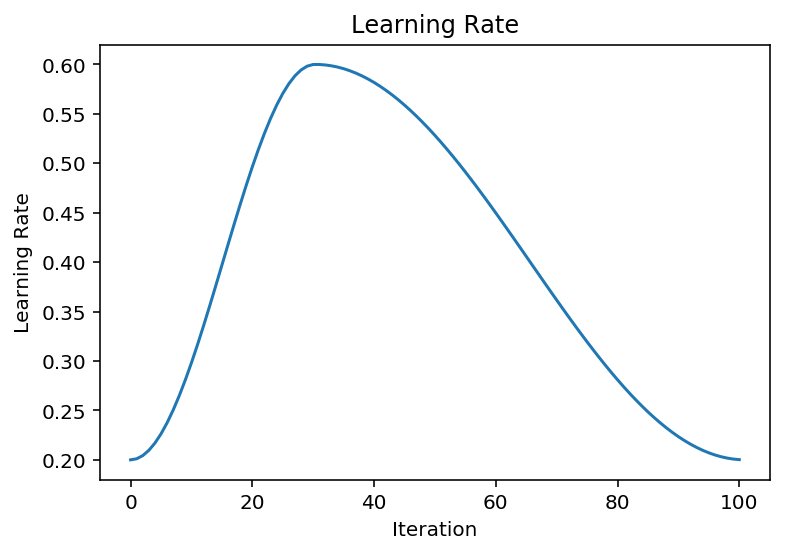

In [ ]:
learn.recorder.plot_lr()

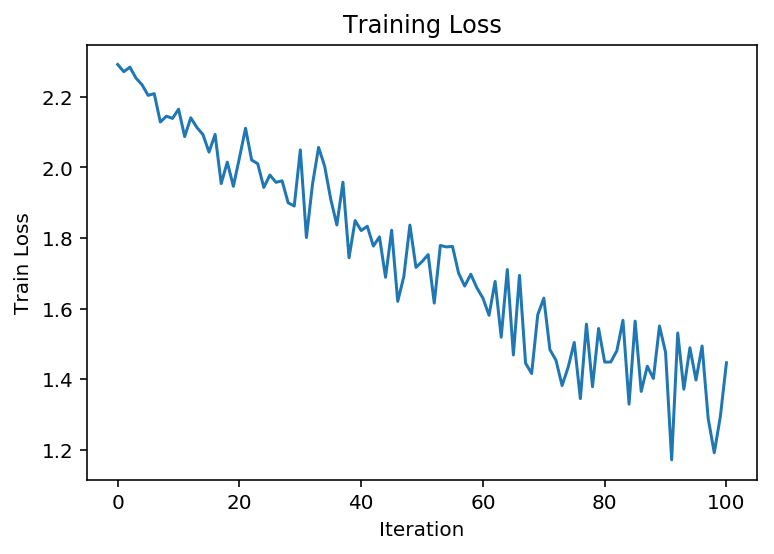

In [ ]:
learn.recorder.plot_loss()

### Adding progress bars to `Learner`



To close out this notebook, we're going to wire [Sylvain Gugger](https://www.fast.ai/about/#sylvain)'s [fastprogress library](https://github.com/fastai/fastprogress) into our new and improved `Learner` class. This will allow us to display beautiful progress bars that illustrate the portion of training that has been completed, both overall and for each individual epoch:

<img src="images/cifar_train.gif" alt="fastprogress" align="left" width="400" />

In [ ]:
#export
import time
from fastprogress import master_bar, progress_bar
from fastprogress.fastprogress import format_time

We'll need to rewrite `AvgStatsCallback` once more. One of the useful things about fastprogress is that it measures training time and displays the expected time until both a single epoch as well as overall training are complete. In order to take advantage of this, `AvgStatsCallback` will need to be able to keep track of the time at the beginning and at the end of an epoch.

`AvgStatsCallback` will also need to be able to print out the names of each metric used to evaluate the model. We'll accomplish this inside of a newly-added `begin_fit()` method.

In [ ]:
#export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats, self.valid_stats = AvgStats(metrics,in_train=True), AvgStats(metrics,in_train=False)
        
    # Keep track of names of all items we're printing out.
    def begin_fit(self):
        metric_names = ['loss'] + [m.__name__ for m in self.train_stats.metrics]
        names = ['epoch'] + [f'train_{n}' for n in metric_names] + [
            f'valid_{n}' for n in metric_names] + ['time']
        self.logger(names)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        # Get the time when an epoch begins.
        self.start_time = time.time()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
       
    # For printing out summary stats of after each epoch.
    def after_epoch(self):
        stats = [str(self.epoch)] # Begin with the epoch's number.
        for o in [self.train_stats, self.valid_stats]:
            # And nicely format all other metrics to be displayed.
            stats += [f'{v:.6f}' for v in o.avg_stats]
        # Also ensure total duration of is displayed.
        stats += [format_time(time.time() - self.start_time)]
        # Use Learner's self.logger function to display the metrics.
        # print is the default but we will pass fastprogress' 
        # write() function to self.logger.
        self.logger(stats)

Now we implement a callback that will display the progress bars:
* `master_bar` displays total training progress.
* `progress_bar` displays progress across all mini-batches in an epoch. We create a new one at the beginning of each epoch's training and validation phases and update it upon each batch's conclusion.

Passing the fastprogress library's `write()` method as `Learner`'s `logger` will allow the progress bars to be displayed.

In [ ]:
#export
class ProgressBarCallback(Callback):
    _order=-1
    def begin_fit(self):
        self.master_bar = master_bar(range(self.epochs))
        self.master_bar.on_iter_begin()
        # Callback class stores the Learner() object under self.run
        self.run.logger = partial(self.master_bar.write, table=True)
        
    def after_fit(self): self.master_bar.on_iter_end()
    def after_batch(self): self.progress_bar.update(self.iter)
    def begin_epoch(self): self.set_progress_bar()
    def begin_validate(self): self.set_progress_bar()
        
    def set_progress_bar(self):
        self.progress_bar = progress_bar(self.dl, parent=self.master_bar, auto_update=False)
        self.master_bar.update(self.epoch)

In [ ]:
callback_funcs = [partial(AvgStatsCallback, accuracy),
                  CudaCallback,
                  ProgressBarCallback,
                  partial(BatchTransformXCallback, norm_imagenette)]

In [ ]:
learn = get_learner(n_outs, data, 0.4, conv_layer, callback_funcs=callback_funcs)

In [ ]:
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.734096,0.403366,1.666434,0.446000,00:12
1,1.298831,0.566077,1.633589,0.472000,00:12


### Export

In [ ]:
nb_auto_export()